<font size="2">
Task 3 notebook - Data science assignment - Andela <br>  author: Joaquín Tempelsman  <br>
date: june 2022 
</font> 



In [26]:
import pandas as pd
import numpy as np
import warnings
import sys

import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression

sys.path.insert(1,'../src')
from data_prep import get_preproccessed_data

warnings.simplefilter(action='ignore')
%matplotlib inline

In [27]:
journeys_df, utilization_df = get_preproccessed_data('../data/', EDA=True)

2022-06-14 22:06:28,968 - root - INFO - preprocessing raw data
2022-06-14 22:06:28,970 - root - INFO - reading journeys data
2022-06-14 22:06:29,105 - root - INFO - reading utilization data
2022-06-14 22:06:29,963 - root - INFO - running data prep 1 on journeys data
2022-06-14 22:06:31,268 - root - INFO - running data prep 1 on utilization data
2022-06-14 22:06:48,141 - root - INFO - running data prep 2 on journey_prep1 data
2022-06-14 22:08:37,150 - root - INFO - data preprocessing complete, returning train dataframe to train module


#### First experiment - Linear Regression - dependant variable = QUANTITY OF TRIPS PER DAY

In [3]:
# DEPENDANT VARIABLE: demand  represented as qty of trips
# INDEPENDENT VARIABLES: 
#   log(CPM_median) - we wil get the price elasticity. Using median to avoid outliers impact.
#   lead_time_median - EDA showed that lead time had a negative impact in price 
#   weekend - weekend as dummy
#   7_to_12hs - time of the day as a dummy

# filter data for SFO, create dummy variable weekend as binary
# we will group qty of trips by date and time of the day, keeping weekend flag
# log transform demand_qty and CPM_median variables so we get % change not absolute values

df = journeys_df.loc[journeys_df.car_parking_address_city == 'San Francisco']
df['weekend'] = np.where(df.weekend == 'weekend',1,0)
df_group = df.groupby(['date','weekend','7_to_12hs']).agg({'trip_id_hash':'count','cost_per_minute':'median','reservation_lead_time':'median'}).reset_index()
df_group.rename(columns={'trip_id_hash':'demand_qty','cost_per_minute':'CPM_median','reservation_lead_time':'lead_time_median'}, inplace=True)
df_group['log_demand_qty'] = np.log(df_group['demand_qty'])
df_group['log_CPM_median'] = np.log(df_group['CPM_median'])

# filter data for LR model
X = df_group[['log_CPM_median','weekend','7_to_12hs','lead_time_median']]
y = df_group['log_demand_qty']

                            OLS Regression Results                            
Dep. Variable:         log_demand_qty   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     912.1
Date:                Mon, 13 Jun 2022   Prob (F-statistic):          1.86e-275
Time:                        23:40:05   Log-Likelihood:                -635.50
No. Observations:                 703   AIC:                             1281.
Df Residuals:                     698   BIC:                             1304.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -4.1085      0.257  

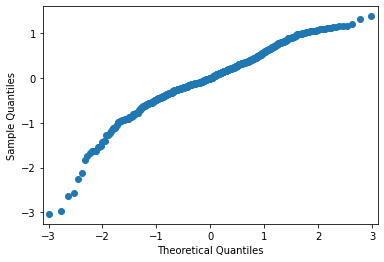

In [4]:
reg = LinearRegression().fit(X, y)
X = sm.add_constant(X)
model = sm.OLS(y,X)
results = model.fit()
print(results.summary())

# VARIANCE INFLATION FACTOR (VIF) - measure of multicollinearity
# over 5 we should consider removing variables
VIF = pd.Series([variance_inflation_factor(X.values, i) 
                 for i in range(X.shape[1])], 
                 index=X.columns)
print(VIF)

fig = sm.qqplot(results.resid)
plt.show()


##### notes
    R2 score is acceptable, the goodnes of fit of the model is enough as a first experiment.
    QQ plots of the residuals show that the residuals are more or less normally distributed.
    parcial significance tests - all with high statistical significance (p-value < 0.05).

    coeficients sign is according to expected
    log_CPM_median: 1% increase in CPM lowers aggregated demand by 2.59% in average
    weekend: demand increases during weekend
    7_to_12hs: demand increases during daytime hours
    lead_time_median: demand segment is lower for bigger lead times

#### Second experiment - Linear Regression - dependant variable = MINUTES DEMANDED

In [5]:
# DEPENDANT VARIABLE: MINUTES DEMANDED
# INDEPENDENT VARIABLES: 
#   log(CPM_median) - we wil get the price elasticity. Using median to avoid outliers impact.
#   lead_time_median - EDA showed that lead time had a negative impact in price 
#   weekend - weekend as dummy
#   7_to_12hs - time of the day as a dummy

# filter data for SFO, create dummy variable weekend as binary
# we will group qty of trips by date and time of the day, keeping weekend flag
# log transform demand_qty and CPM_median variables so we get % change not absolute values

df = journeys_df.loc[journeys_df.car_parking_address_city == 'San Francisco']
df['weekend'] = np.where(df.weekend == 'weekend',1,0)
df_group = df.groupby(['date','weekend','7_to_12hs']).agg({'trip_duration':'sum','cost_per_minute':'median','reservation_lead_time':'median'}).reset_index()
df_group.rename(columns={'trip_duration':'demand_minutes','cost_per_minute':'CPM_median','reservation_lead_time':'lead_time_median'}, inplace=True)
df_group['log_demand_minutes'] = np.log(df_group['demand_minutes'])
df_group['log_CPM_median'] = np.log(df_group['CPM_median'])

#X = df_group[['log_CPM_median','weekend','7_to_12hs','lead_time_median']] #removed lead_time median
#for failing t test. Can study deeply in further experiments.

X = df_group[['log_CPM_median','weekend','7_to_12hs']]
y = df_group['log_demand_minutes']

                                 OLS Regression Results                                
Dep. Variable:     log_demand_minutes   R-squared (uncentered):                   0.994
Model:                            OLS   Adj. R-squared (uncentered):              0.994
Method:                 Least Squares   F-statistic:                          3.971e+04
Date:                Mon, 13 Jun 2022   Prob (F-statistic):                        0.00
Time:                        23:40:05   Log-Likelihood:                         -771.06
No. Observations:                 703   AIC:                                      1548.
Df Residuals:                     700   BIC:                                      1562.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

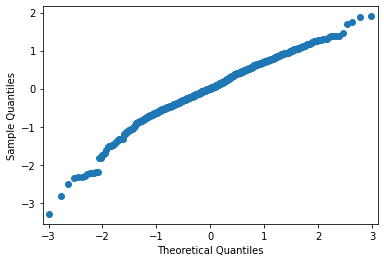

In [6]:

reg = LinearRegression().fit(X, y)
#X = sm.add_constant(X) # removed constant
model = sm.OLS(y,X)
results2 = model.fit()
print(results2.summary())

# VARIANCE INFLATION FACTOR (VIF) - measure of multicollinearity
# over 5 we should consider removing variables
VIF =pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns)
print(VIF)
fig = sm.qqplot(results2.resid)
plt.show()

##### notes
    R2 score is very good.
    QQ plots of the residuals improved a little on the tails compared to first experiment.
    parcial significance tests - all with high statistical significance (p-value < 0.05).
    improvement on log(log_CPM_median) t-test value

    coeficients sign is according to expected
    log_CPM_median: 1% increase in CPM lowers aggregated demand by 3.43% in average
    weekend: demand increases during weekend
    7_to_12hs: demand increases during daytime hours

#### Prescriptive solution

    The following solution objective is to get get the free capacity of the fleet to a target level.
    We will obtain this objective by proponsing a modification on the price witch will impact on the
    demand level. 
    
    We will propose a target_used_capacity parameter = 100% at first but this can be further discussed.
    This target should be settled with more analysis that are outside the scope of this solution.
    If we can add cost data we could optimize target capacity watching income (dependant variable)

    The target capacity is a soft objective. We set a restriction that we cannot modify
    the price in more than a price_variation_cap = 30% both for positive or negative 
    variation on price.

    As currently most of the fleet per hour per zipcode is having free capacity, most of the 
    price modifications will be to lower the price except the fleet at that zip code if at
    full capacity so the price proposed will be negative.   

In [7]:

# parameters
target_used_capacity = 0.9
price_var_cap = - 15

# get the coeficient from the second experiment
coeficient = results.params['log_CPM_median'] 
print('using coefficient: ', results.params['log_CPM_median'])

#filter data
utilization_df_SFO = utilization_df.loc[utilization_df.car_parking_address_city == 'San Francisco']

# group data by sfo zip code and date
group_sfo_data = (utilization_df_SFO.groupby(['car_hourly_utilization_aggregated_at_time',
                                             'car_parking_address_postcode']).sum()
                                                 [['car_hourly_unused_minutes',
                                                   'car_hourly_utilization_sum_utilized_minutes',
                                                   'car_hourly_utilization_sum_available_minutes']]
                                                   .reset_index())

# the capacity in minutes summing unused minutes + used minutes
group_sfo_data['total_capacity'] = (group_sfo_data['car_hourly_unused_minutes'] + 
                                    group_sfo_data['car_hourly_utilization_sum_utilized_minutes']
                                    )

# target capacity as a percentage of the total capacity
group_sfo_data['target_used_capacity'] = group_sfo_data['total_capacity'] * target_used_capacity

# this is the teorical delta we want to achieve
group_sfo_data['target_demand_perc_var'] = (((group_sfo_data['target_used_capacity'] 
                                            - group_sfo_data['car_hourly_utilization_sum_utilized_minutes']) 
                                            / group_sfo_data['car_hourly_utilization_sum_utilized_minutes']) 
                                            * 100 
                                            )

#null correction for cases with no capacity
group_sfo_data['target_demand_perc_var'] = (np.where(group_sfo_data['total_capacity'] <= 0,
                                            0, group_sfo_data['target_demand_perc_var'])
                                            )

# using the coeficient we get the percentual price variation required to get to the target capacity
group_sfo_data['raw_price_var_sugested'] = group_sfo_data['target_demand_perc_var'] / coeficient

# we cap the price variation to the treshold set at 'price_var_cap' variable
group_sfo_data['cap_price_var_sugested'] = (np.where(group_sfo_data['raw_price_var_sugested'] < price_var_cap,
                                            price_var_cap, group_sfo_data['raw_price_var_sugested'])
                                            )

group_sfo_data['cap_price_var_sugested'] = (np.where(group_sfo_data['cap_price_var_sugested'] > abs(price_var_cap),
                                            price_var_cap, group_sfo_data['cap_price_var_sugested'])
                                            )

# get new teorical demand data based on the new caped_price variation sugestion
group_sfo_data['new_teorical_demand'] = (group_sfo_data['car_hourly_utilization_sum_utilized_minutes'] 
                                         * (100 + group_sfo_data['cap_price_var_sugested'] 
                                         * coeficient) 
                                         / 100 )

using coefficient:  -2.5855202683019436


count    160378.000000
mean        -12.910690
std           5.292687
min         -15.000000
25%         -15.000000
50%         -15.000000
75%         -15.000000
max           3.867694
Name: cap_price_var_sugested, dtype: float64

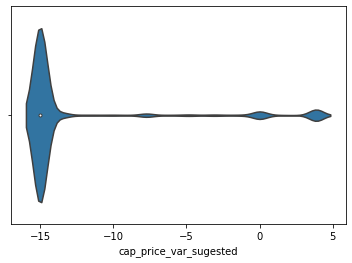

In [8]:
sns.violinplot(group_sfo_data.cap_price_var_sugested)
group_sfo_data['cap_price_var_sugested'].describe()

<Figure size 1440x576 with 0 Axes>

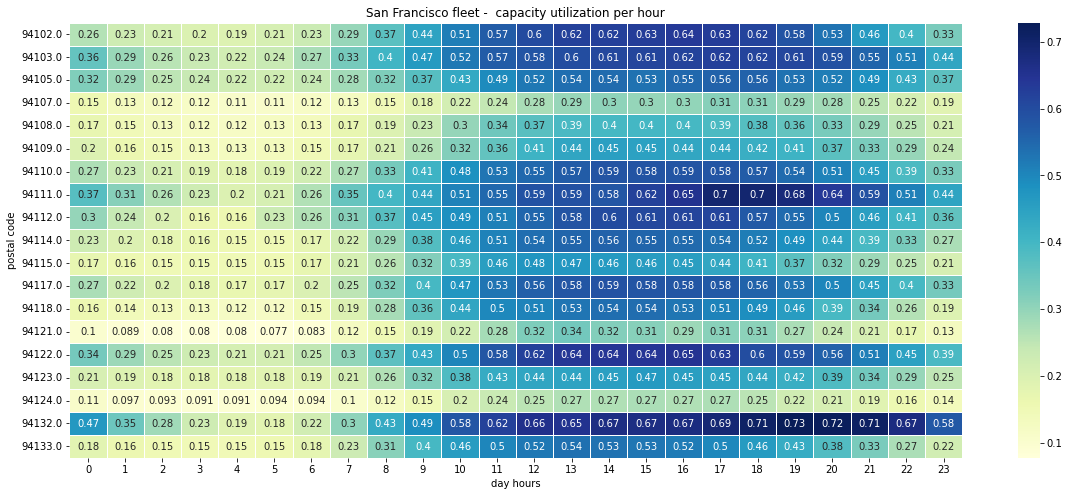

In [9]:
# we will repeat the capacity per hour plot in task1 with the new theorical demand obtained from applying the solution

group_sfo_data['hour'] = group_sfo_data.car_hourly_utilization_aggregated_at_time.dt.hour
group_sfo_data['relative_teorical_used_capacity'] = group_sfo_data['new_teorical_demand'] / group_sfo_data['car_hourly_utilization_sum_available_minutes']


SFO_heatmap_pivot = pd.pivot_table(group_sfo_data, values='relative_teorical_used_capacity', index='car_parking_address_postcode', columns='hour')
plt.figure(figsize=(20,8))
f, ax = plt.subplots(figsize=(20, 8))
sns.heatmap(SFO_heatmap_pivot, annot=True, linewidths=.5, ax=ax, cmap="YlGnBu")
ax.set(xlabel='day hours', ylabel='postal code', title='San Francisco fleet -  capacity utilization per hour')
plt.savefig("heatmap_task3.png")



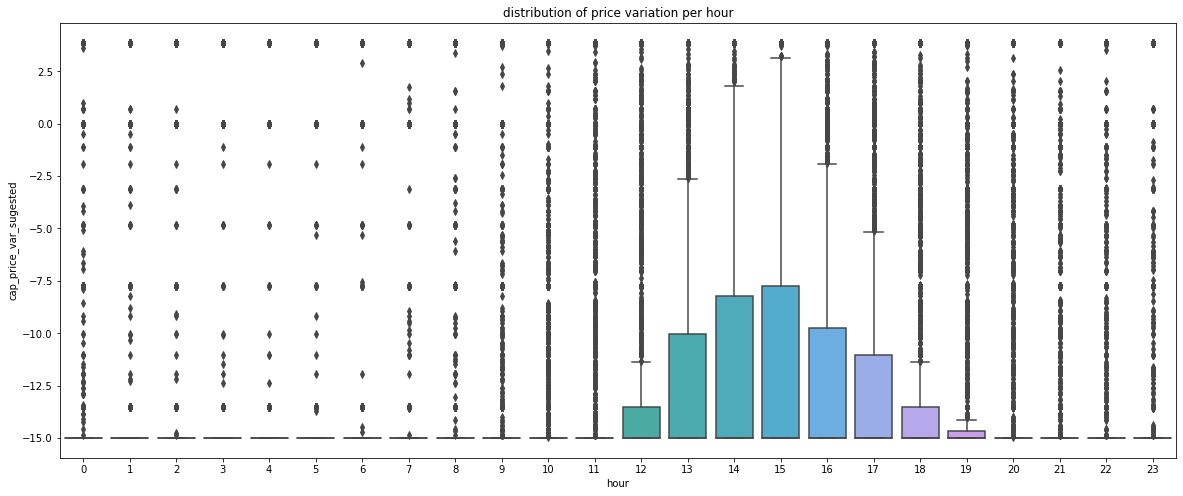

In [10]:
plt.figure(figsize=(20,8))
ax =sns.boxplot(data=group_sfo_data, x='hour', y='cap_price_var_sugested')
ax.set(title='distribution of price variation per hour')

plt.savefig("boxplot_task3.png")